![Futuristic electric car charging](ev_charging.png)

The US Government's Alternative Fuels Data Center collects records of electric vehicle (EV) charging infrastructure, including charging ports and station locations, as well as sales of electric vehicles. With the EV market rapidly evolving, understanding trends in charging facilities and sales is essential to inform strategic planning.

As a data scientist working for a leading EV charging network operator, you recognize the potential in this data and start wrangling and visualizing the aggregated yearly data. 

This yearly data captured in December of each year encompasses a record of EV charging port installations and station localities spanning roughly ten years, capturing both public and private charging environments. 
___

### The Data
&nbsp;

`private_ev_charging.csv`

| Variable   | Description                                          |
|------------|------------------------------------------------------|
| `year` |  Year of data collection |
| `private_ports`| The number of available charging ports owned by private companies in a given year  |
| `private_station_locations`   | The number of privately owned station locations for EV charging

___

`public_ev_charging.csv`
 
| Variable   | Description                                          |
|------------|------------------------------------------------------|
| `year` |  Year of data collection  |
| `public_ports`| The number of available charging ports under public ownership in a given year  |
| `public_station_locations`   | The number of publicly owned station locations for EV charging

___

The sales information is available for each model and year in the `ev_sales.csv` file:

| Variable   | Description                                          |
|------------|------------------------------------------------------|
| `Vehicle` |  Electric vehicle model |
| `year`| Year of data collection |
| `sales`   | The number of vehicles sold in the US

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

In [2]:
private = pd.read_csv('private_ev_charging.csv')
public = pd.read_csv('public_ev_charging.csv')
sales = pd.read_csv('ev_sales.csv')

In [3]:
# High level exploratory analysis
for i in (private,public,sales):
    print(i.info())
    print(i.describe())
    print(i.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   year                       9 non-null      int64
 1   private_ports              9 non-null      int64
 2   private_station_locations  9 non-null      int64
dtypes: int64(3)
memory usage: 344.0 bytes
None
              year  private_ports  private_station_locations
count     9.000000       9.000000                   9.000000
mean   2018.000000    9547.777778                2814.666667
std       2.738613    6070.143836                 903.266572
min    2014.000000    3695.000000                1825.000000
25%    2016.000000    5763.000000                2331.000000
50%    2018.000000    6812.000000                2489.000000
75%    2020.000000   10647.000000                3078.000000
max    2022.000000   19993.000000                4435.000000
year                         0
pr

In [4]:
# Examining if there are any duplicated values
for dup in (private,public,sales):
    print(dup[dup.duplicated()])

Empty DataFrame
Columns: [year, private_ports, private_station_locations]
Index: []
Empty DataFrame
Columns: [year, public_ports, public_station_locations]
Index: []
Empty DataFrame
Columns: [Vehicle, year, sales]
Index: []


            Vehicle  year  sales
34  Mitsubishi I EV  2018    NaN
35  Mitsubishi I EV  2019    NaN
36     BMW Active E  2011    NaN
38     BMW Active E  2013    NaN
39     BMW Active E  2014    NaN
40     BMW Active E  2015    NaN
41     BMW Active E  2016    NaN
42     BMW Active E  2017    NaN
43     BMW Active E  2018    NaN
44     BMW Active E  2019    NaN
            Vehicle  year   sales
27  Mitsubishi I EV  2011    76.0
28  Mitsubishi I EV  2012   588.0
29  Mitsubishi I EV  2013  1029.0
30  Mitsubishi I EV  2014   196.0
31  Mitsubishi I EV  2015   115.0
32  Mitsubishi I EV  2016    94.0
33  Mitsubishi I EV  2017     6.0
34  Mitsubishi I EV  2018     NaN
35  Mitsubishi I EV  2019     NaN


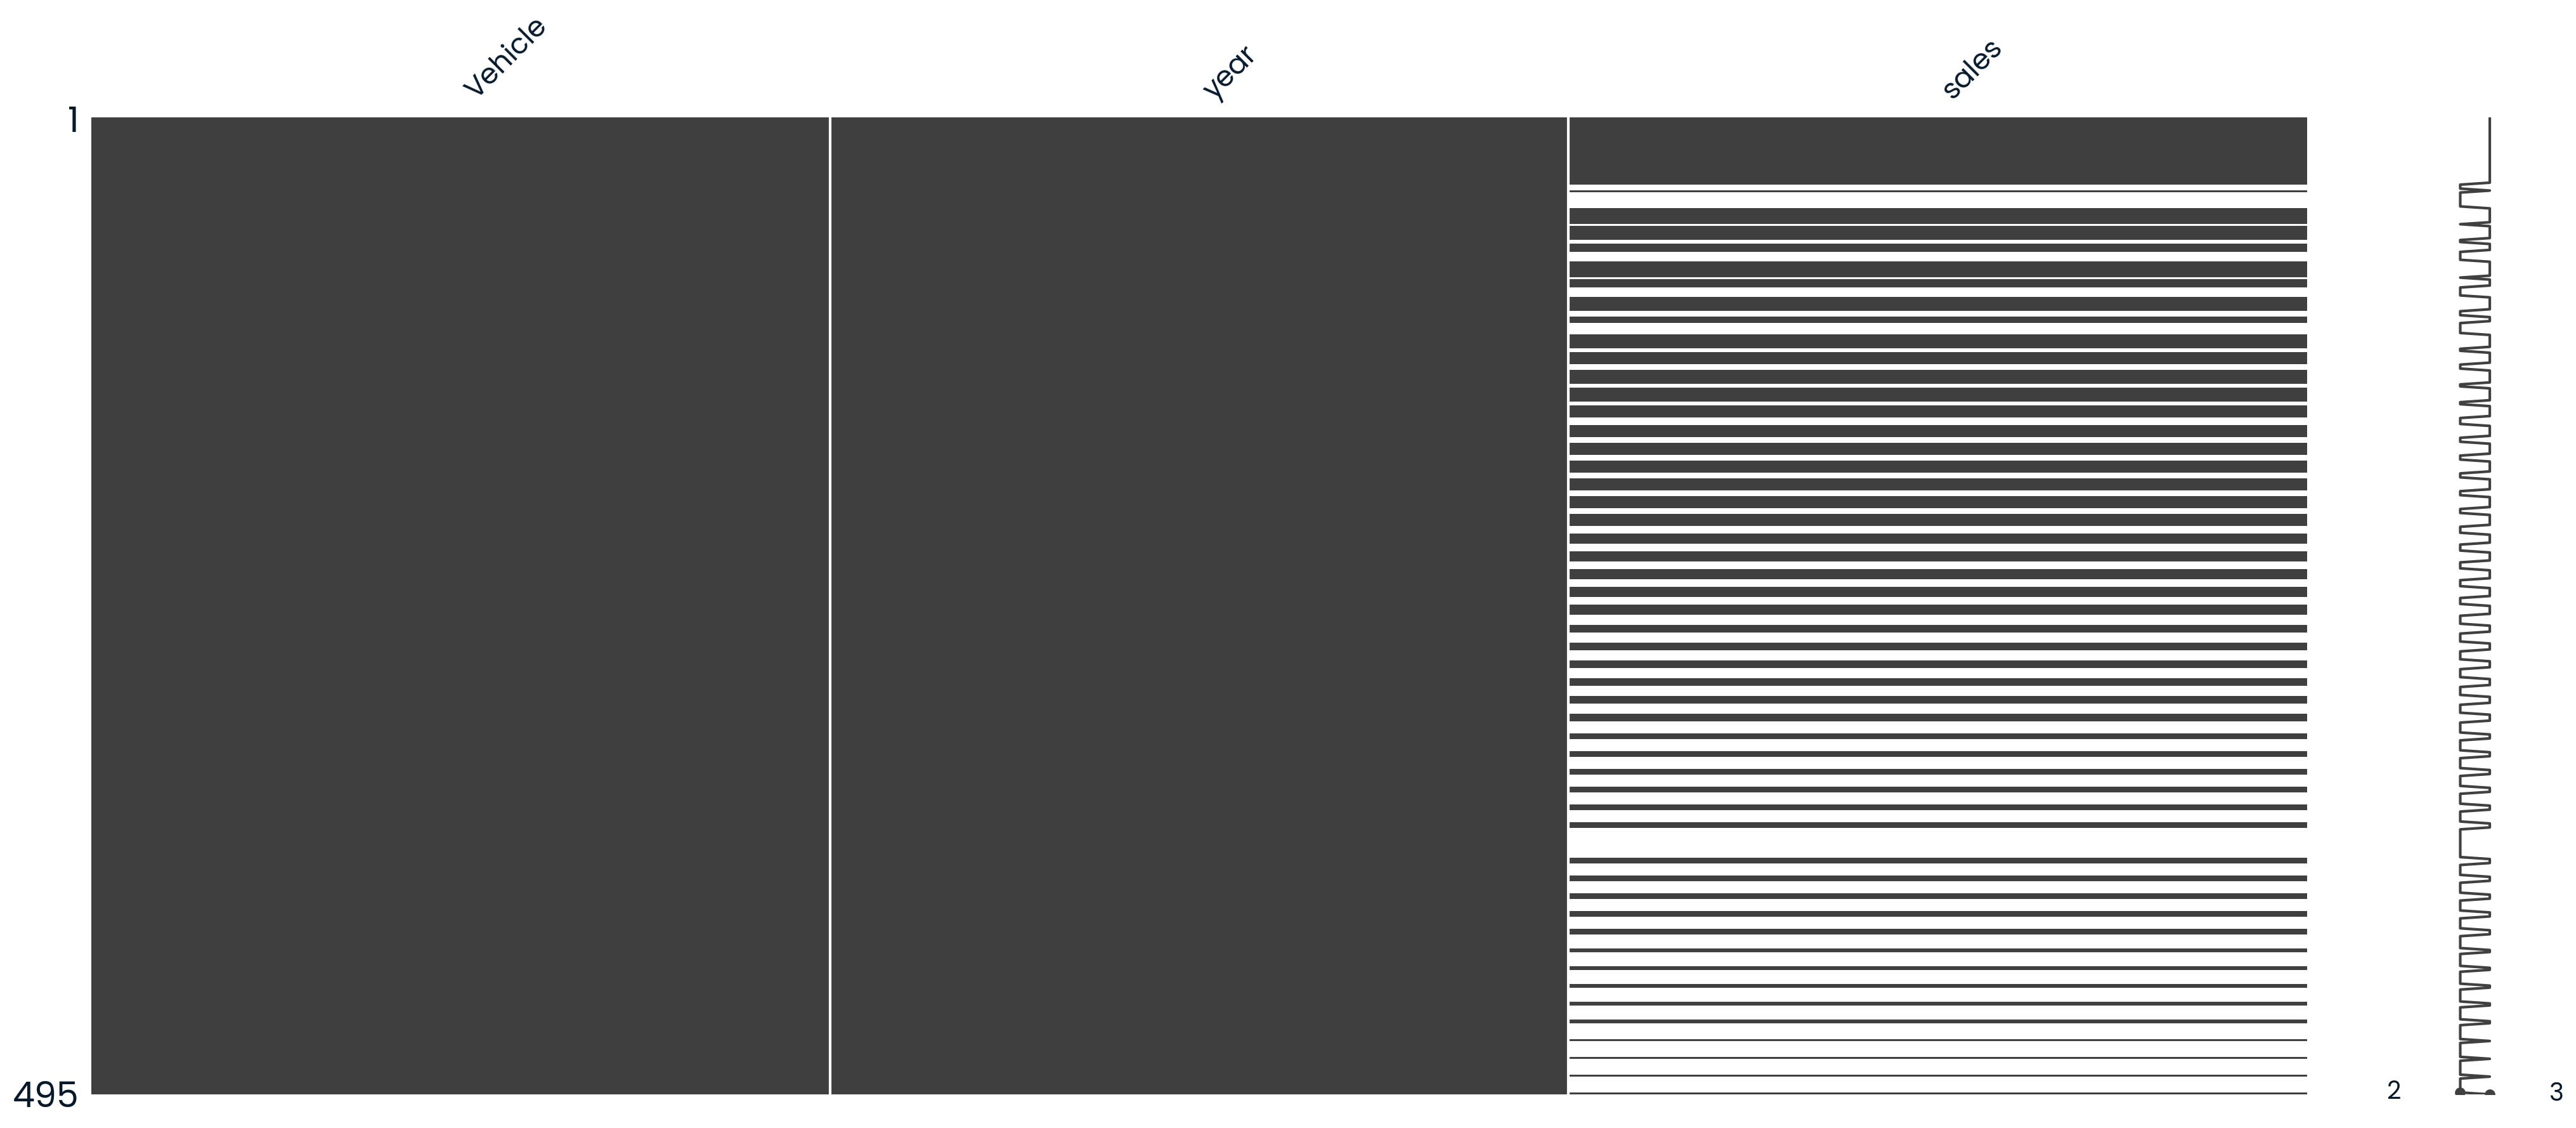

                                  count_sales  count_missing_values
Vehicle                                                            
Audi A3 Plug In                             4                     5
Audi e-tron                                 1                     8
BMW 3-series Plug-In                        4                     5
BMW 5-Series Plug in                        3                     6
BMW 7-series Plug-in                        4                     5
BMW Active E                                1                     8
BMW X5                                      5                     4
BMW i3                                      6                     3
BMW i8                                      6                     3
Cadillac CT6                                3                     6
Cadillac ELR                                6                     3
Chevy Bolt                                  4                     5
Chevy Spark                                 6   

In [5]:
# Roughly 50% of the Vehicle column consists of missing values,examine what is the missing values pattern
import missingno as msno

print(sales[sales['sales'].isna()].head(10))
print(sales[sales['Vehicle']=='Mitsubishi I EV'])

# Visualise the missing values

msno.matrix(sales)
plt.show()

# Group missing values per car to demonstrate the missing values visual
grouped_missing = sales.groupby('Vehicle').agg(
                                               count_sales = ('sales', lambda x: x.notna().sum()),
                                               count_missing_values = ('sales', lambda x: x.isna().sum())
                                              )
print(grouped_missing)


In [6]:
# I will imput the missing values to 0.

sales['sales'] = sales['sales'].fillna(0)
print(sales.isna().sum())

Vehicle    0
year       0
sales      0
dtype: int64


In [7]:
# Group the sales dataframe on years in order to merge it with the other dataframes. I will agg with sales sum since there is no need to track specific models sales patterns in thei project.

sales_grouped = sales.groupby('year')['sales'].agg(sum).reset_index()
print(sales_grouped)

ev_sales_2018 = sales_grouped[sales_grouped['year']==2018]['sales'].values[0]

print(f"In 2018 {ev_sales_2018} EVs were sold")

   year     sales
0  2011   17763.0
1  2012   53171.0
2  2013   97102.0
3  2014  118882.0
4  2015  114023.0
5  2016  159616.0
6  2017  195581.0
7  2018  361315.0
8  2019  326644.0
In 2018 361315.0 EVs were sold


In [8]:
# I will merge the 3 dataframes on the year column

df = public.merge(private, on = 'year', how='left')\
                  .merge(sales_grouped, on = 'year', how = 'outer', suffixes=['_private','_sales'])\
                  .sort_values('year')

print(df)
print(df.info())

    year  public_ports  ...  private_station_locations     sales
10  2011           NaN  ...                        NaN   17763.0
11  2012           NaN  ...                        NaN   53171.0
0   2013       16619.0  ...                        NaN   97102.0
1   2014       22470.0  ...                     1825.0  118882.0
2   2015       26532.0  ...                     1962.0  114023.0
3   2016       33165.0  ...                     2331.0  159616.0
4   2017       45789.0  ...                     2370.0  195581.0
5   2018       56842.0  ...                     2489.0  361315.0
6   2019       73838.0  ...                     3078.0  326644.0
7   2020       96190.0  ...                     2768.0       NaN
8   2021      114451.0  ...                     4074.0       NaN
9   2022      136513.0  ...                     4435.0       NaN

[12 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 10 to 9
Data columns (total 6 columns):
 #   Column                   

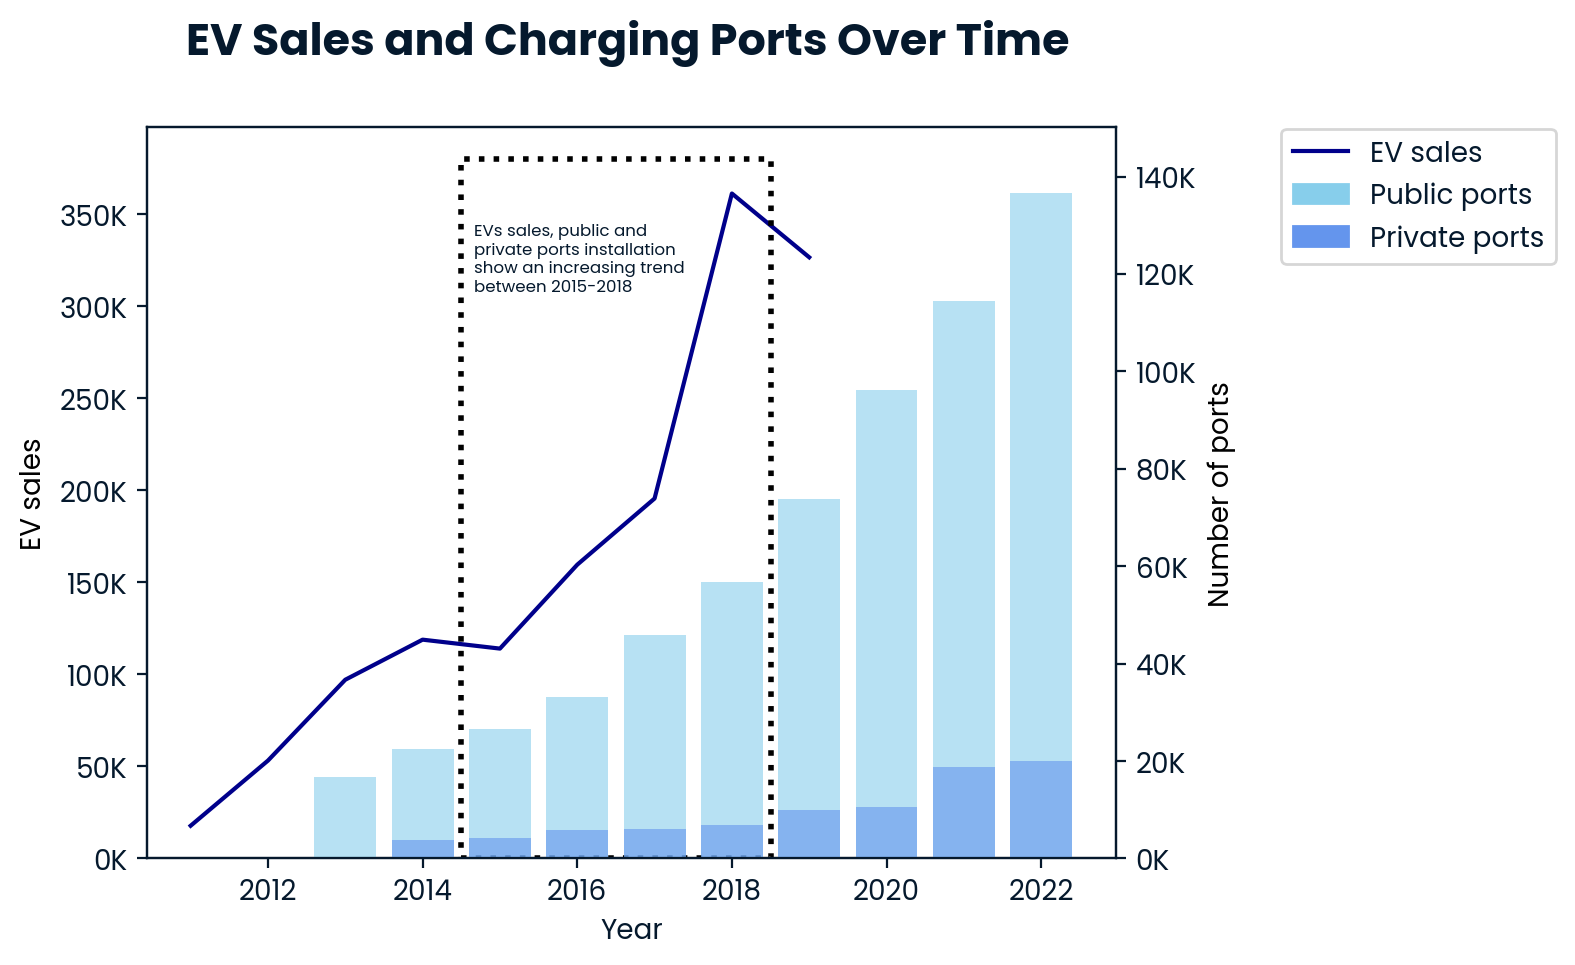

In [11]:
# Plot trends of sales, private and public ports with Matplotlib

fig,ax = plt.subplots()

# Set title
fig.suptitle('EV Sales and Charging Ports Over Time', fontsize=16, fontweight='bold', y=1)

# Plot 1 - sales (line)
line_plot = ax.plot(df['year'],df['sales'], color='darkblue', label='EV sales')
ax.set_xlabel('Year')
ax.set_ylabel('EV sales', color = 'black')

# Plot 2+3 - ports with different y axis due to scale and bar plots
ax2 = ax.twinx()
bar_plot1 = ax2.bar(df['year'], df['public_ports'], color='skyblue', alpha=0.6, label='Public ports')
bar_plot2 = ax2.bar(df['year'], df['private_ports'], \
                   color='cornflowerblue', alpha=0.6, label='Private ports')
ax2.set_ylabel('Number of ports', color='black')

# Align the 0 for both y axes
ax.set_ylim(0, df['sales'].max() * 1.1) 
ax2.set_ylim(0, max(df['public_ports'].max(), df['private_ports'].max()) * 1.1)


# Adjust the y axes to K

def custom_formatter(x, pos):
    return f'{x * 1e-3:.0f}K'

ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter))


# Implement a legend
handles, labels = [], []
handles.append(line_plot[0]) 
labels.extend(['EV sales'])

handles.append(Patch(color='skyblue', label='Public ports'))
labels.append('Public ports')

handles.append(Patch(color='cornflowerblue', label='Private ports'))
labels.append('Private ports')

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.tight_layout()

# Implement a dotted rectangle to highlight the data asked in the question
corner1 = (2014.5, 0)
corner2 = (2018.5, 0)
corner3 = (2018.5, 380000)
corner4 = (2014.5, 380000)

x_coords = [corner1[0], corner2[0], corner3[0], corner4[0], corner1[0]]
y_coords = [corner1[1], corner2[1], corner3[1], corner4[1], corner1[1]]

ax.plot(x_coords, y_coords, linestyle='dotted', color='black',linewidth=2)

# Add a findings text
summary_text = """
EVs sales, public and 
private ports installation 
show an increasing trend 
between 2015-2018
"""

fig.text(0.38, 0.75, summary_text, ha='left', va='center', fontsize=6)

plt.show()
